In [16]:
%pip install pandas seaborn matplotlib 

  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
  Using cached fonttools-4.60.1-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
  Using cached pillow-11.3.0-cp39-cp39-macosx_11_0_arm64.whl (4.7 MB)
     |████████████████████████████████| 249 kB 33 kB/s eta 0:00:01
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     |████████████████████████████████| 64 kB 308 kB/s eta 0:00:01
You should consider upgrading via the '/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_dir = current_dir.parent / "drafts"

files = list(draft_dir.glob("draft_*.csv"))

df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    df = pd.concat([df, curr_df])

df = df.sort_values(by=["SEASON", "OVERALL_PICK"]) 
df.to_csv(draft_dir / "drafts.csv", index=False)

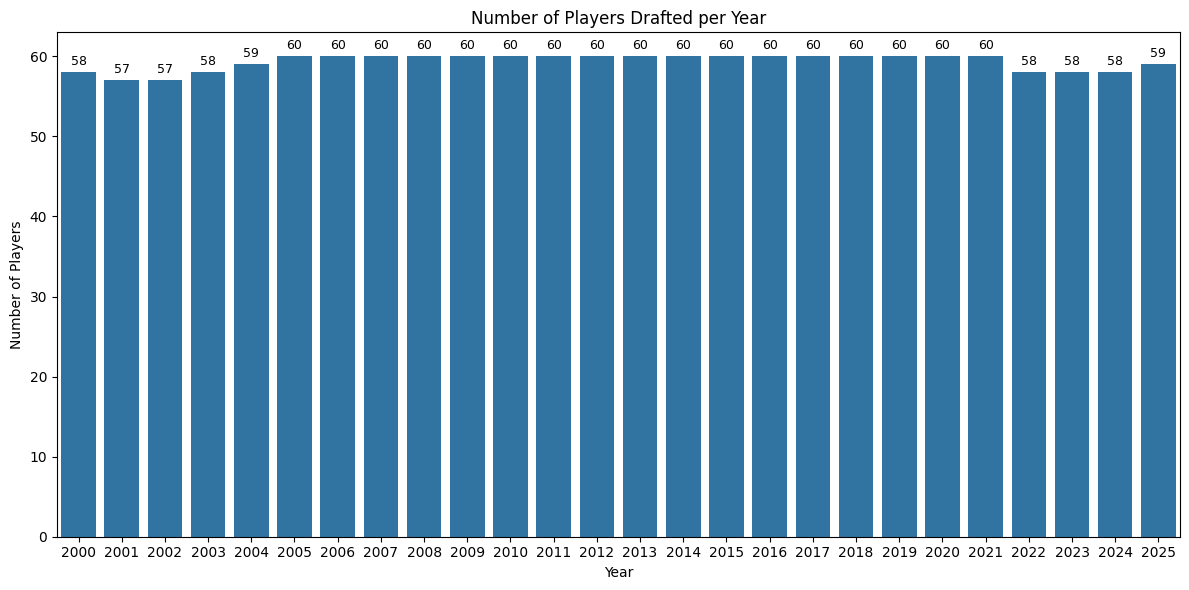

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()

In [17]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
draft_combine_dir = current_dir.parent / "draft_combine"

files = list(draft_combine_dir.glob("draft_combine*.csv"))

df = pd.DataFrame()
for file in files:
    curr_df = pd.read_csv(file)
    df = pd.concat([df, curr_df])

df = df.sort_values(by=["SEASON"]) 
df.to_csv(draft_combine_dir / "draft_combine_full.csv", index=False)


Duplicate rows in draft_combine_df: 0
Duplicate rows in draft_df: 0


In [24]:
draft_combine_df = pd.read_csv(draft_combine_dir / "draft_combine_full.csv")
draft_df = pd.read_csv(draft_dir / "drafts.csv")


# --- merge both datasets (keep all columns from both) ---
merged_df = pd.merge(
    draft_combine_df,
    draft_df,
    left_on=["PLAYER_ID", "SEASON"],
    right_on=["PERSON_ID", "SEASON"],
    how="inner",
    suffixes=("_COMBINE", "_DRAFT")
)

# --- save merged file ---
output_path = draft_dir / "draft_combine_full_merged.csv"
merged_df.to_csv(output_path, index=False)


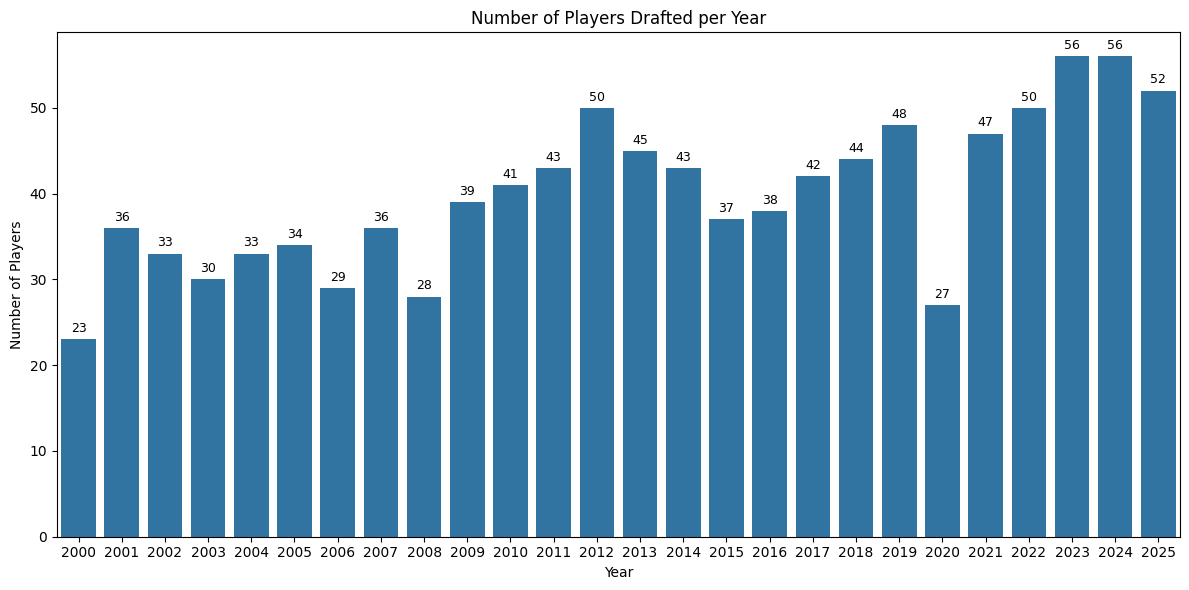

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=merged_df, x="SEASON", ax=ax)
ax.set_title("Number of Players Drafted per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Players")

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        f"{count}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center", va="bottom",
        fontsize=9, xytext=(0, 3), textcoords="offset points"
    )

plt.tight_layout()
plt.show()

### Data Preprocessing

In [30]:
df = pd.read_csv(draft_dir / "draft_combine_full_merged.csv")

In [32]:
"""
Purpose: remove duplicate/overlapping columns created by the merge and enforce one row per player-season

1.PLAYER_ID and PERSON_ID are the same after merge -> keep one
2.PLAYER_NAME_COMBINE and PLAYER_NAME_DRAFT are the same -> keep one standardized name

"""
drop_cols = [c for c in ["PERSON_ID", "PLAYER_NAME_DRAFT"] if c in df.columns]
df = df.drop(columns=drop_cols)

if "PLAYER_NAME_COMBINE" in df.columns:
    df = df.rename(columns={"PLAYER_NAME_COMBINE": "PLAYER_NAME"})


print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [ ]:
# Purpose: convert "6' 8''" style strings to numeric inches (and optional centimeters)

import pandas as pd
import re

def ft_in_to_inches(s):
    """Convert strings like 6' 8'' or 6' 8.5'' to inches. Returns None if unparsable."""
    if pd.isna(s):
        return None
    s = str(s)
    # Match feet and optional inches (handles 6' 8, 6' 8'', 6'8", 6' 8.5'')
    m = re.search(r"(\d+)\s*'\s*([\d\.]+)?", s)
    if not m:
        return None
    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) is not None else 0.0
    return round(feet * 12 + inches, 2)

ft_in_cols = ["HEIGHT_WO_SHOES_FT_IN", "HEIGHT_W_SHOES_FT_IN",
              "WINGSPAN_FT_IN", "STANDING_REACH_FT_IN"]

for col in ft_in_cols:
    if col in df.columns:
        out_col = col.replace("_FT_IN", "_INCHES")
        df[out_col] = df[col].apply(ft_in_to_inches)

# Optional: provide a convenient centimeters column for height (without shoes)
if "HEIGHT_WO_SHOES_INCHES" in df.columns:
    df["HEIGHT_WO_SHOES_CM"] = df["HEIGHT_WO_SHOES_INCHES"] * 2.54

df[ [c for c in df.columns if c.endswith("INCHES")] + ["HEIGHT_WO_SHOES_CM"] ].head(5)

,HEIGHT_WO_SHOES_INCHES,HEIGHT_W_SHOES_INCHES,WINGSPAN_INCHES,STANDING_REACH_INCHES,HEIGHT_WO_SHOES_CM
0,76.5,NaN,82.0,102.5,194.31
1,80.0,NaN,84.5,104.5,203.20
2,81.0,NaN,80.0,104.0,205.74
3,76.0,NaN,80.0,102.5,193.04
4,78.5,NaN,81.0,104.0,199.39


In [36]:
# Purpose: ensure numeric columns are true numbers (floats/ints), not strings

numeric_cols = [
    "HEIGHT_WO_SHOES", "HEIGHT_W_SHOES", "WEIGHT", "WINGSPAN",
    "STANDING_REACH", "BODY_FAT_PCT", "HAND_LENGTH", "HAND_WIDTH",
    "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP",
    "LANE_AGILITY_TIME", "MODIFIED_LANE_AGILITY_TIME",
    "THREE_QUARTER_SPRINT", "BENCH_PRESS",
    "ROUND_NUMBER", "ROUND_PICK", "OVERALL_PICK", "TEAM_ID", "PLAYER_PROFILE_FLAG"
]
existing_numeric_cols = [c for c in numeric_cols if c in df.columns]
df[existing_numeric_cols] = df[existing_numeric_cols].apply(pd.to_numeric, errors="coerce")

df[existing_numeric_cols].dtypes

HEIGHT_WO_SHOES               float64
HEIGHT_W_SHOES                float64
WEIGHT                        float64
WINGSPAN                      float64
STANDING_REACH                float64
BODY_FAT_PCT                  float64
HAND_LENGTH                   float64
HAND_WIDTH                    float64
STANDING_VERTICAL_LEAP        float64
MAX_VERTICAL_LEAP             float64
LANE_AGILITY_TIME             float64
MODIFIED_LANE_AGILITY_TIME    float64
THREE_QUARTER_SPRINT          float64
BENCH_PRESS                   float64
ROUND_NUMBER                    int64
ROUND_PICK                      int64
OVERALL_PICK                    int64
TEAM_ID                         int64
PLAYER_PROFILE_FLAG             int64
dtype: object